## Prep cells

This section loads tokenizer-level metrics (`timtc_metrics_cleaned-tok_metrics.csv`) and model-level metrics (`timtc_metrics_cleaned-mod_metrics.csv`), aligns them on shared configuration keys, and builds a correlation matrix used by the rest of the notebook.

- **Join keys (`join_cols`)**: `vocab_size`, `vocab_construct`, `vocab_init`, `pre-tok`, `segment`.
- **`tok_cols`**: subset of tokenizer metrics to visualize/compare (excludes leading-space counts/shares).
- **`mod_cols`**: model performance metrics (excludes identifier columns like `tokenizer` and `xcopa` where relevant).
- **`for_corr`**: numeric analysis-ready table after dropping non-comparable columns.
- **`corr_matrix`**: Pearson correlations across all numeric columns in `for_corr` (reused below).

In [9]:
import polars as pl 

mod_metrics = pl.read_csv("timtc_metrics_cleaned-mod_metrics.csv")
tok_metrics = pl.read_csv("timtc_metrics_cleaned-tok_metrics.csv")

tok_cols = [
    c for c in tok_metrics.columns
    if "leading_space_tokens_count" not in c and "leading_space_tokens_share" not in c
]
mod_cols = [c for c in mod_metrics.columns if c not in ("tokenizer", "xcopa")]
join_cols = ["vocab_size","vocab_construct", "vocab_init", "pre-tok", "segment"]

joined_metrics = tok_metrics.join(
    mod_metrics,
    how='left', 
    on=join_cols,
    nulls_equal=True,
)

for_corr = (
    joined_metrics
    .select(
        pl.exclude("vocab_size", "vocab_construct", "vocab_init", "pre-tok", "segment"), # Join cols
    )
    .select(
        pl.exclude("chars_total"), # other exclusions
    )
    .select(
        pl.exclude("leading_space_tokens_count", "leading_space_tokens_share")
    )
    .to_pandas()
)

corr_matrix = for_corr.corr(numeric_only=True)
#corr_matrix

## OG correlation

This section visualizes correlations between model performance metrics (rows) and tokenizer metrics (columns).

- The heatmap shows the **signed correlation (r)** as annotations, while color intensity is scaled by **|r|** (magnitude), making strong relationships easier to spot.
- Columns are ordered by the mean absolute correlation across selected rows, surfacing the most informative tokenizer metrics first.
- Axis labels, colorbar range, and layout are tuned for readability across many metrics.

<Figure size 2800x2000 with 0 Axes>

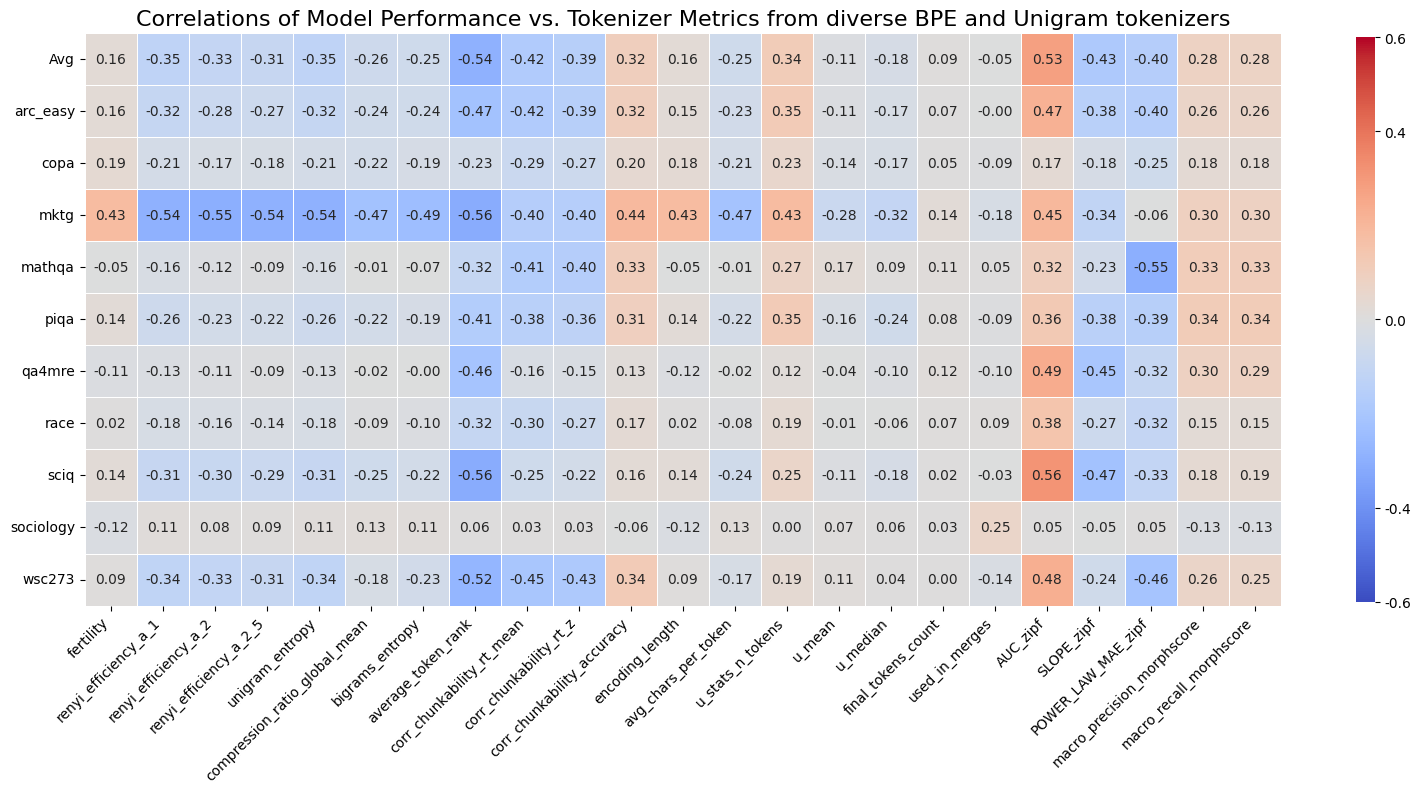

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(28, 20))

# Use filtered columns only in the heatmap, intersect with available labels
row_keys = [c for c in mod_cols if c in corr_matrix.index]
col_keys = [c for c in tok_cols + join_cols if c in corr_matrix.columns]
masked_corr = corr_matrix.loc[row_keys, col_keys]
masked_corr_sq = masked_corr * abs(masked_corr)


row_order = masked_corr.index
# Sort columns by descending mean absolute correlation across the selected rows
col_order = masked_corr.loc[row_order].abs().mean(axis=0).sort_values(ascending=False).index
sorted_corr = masked_corr.loc[row_order, col_order]

masked_corr_sq = masked_corr * masked_corr.abs()

plt.figure(figsize=(16, 10))
hmap = sns.heatmap(
    masked_corr_sq,
    annot=masked_corr, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5,
    vmin=-0.6,
    vmax=0.6,
    square=True,
    cbar_kws={"shrink": 0.6, "aspect": 30},
)
plt.title('Correlations of Model Performance vs. Tokenizer Metrics from diverse BPE and Unigram tokenizers', fontsize=16)

cbar = hmap.collections[0].colorbar
cbar.set_ticks([-0.6, -0.4, 0.0, 0.4, 0.6])
cbar.set_ticklabels(['-0.6', '-0.4', '0.0', '0.4', '0.6'])
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Select informative, non-redundant tokenizer metrics

Goal: find tokenizer metrics that relate strongly to overall model performance (`Avg`) while avoiding redundancy.

- Compute each tokenizer metric’s correlation with `Avg`.
- Keep metrics with **|r(Avg, metric)| ≥ `min_abs_corr`** .
- Greedily add metrics that are not too correlated with those already selected (pairwise **|r| ≤ `redundancy_threshold`**).
- Result: a compact set `selected` that is both predictive and diverse.


Top correlations to Avg (abs)
average_token_rank           0.541685
AUC_zipf                     0.527074
SLOPE_zipf                   0.429981
corr_chunkability_rt_mean    0.417218
POWER_LAW_MAE_zipf           0.403060
corr_chunkability_rt_z       0.390120
unigram_entropy              0.349166
renyi_efficiency_a_1         0.349166
u_stats_n_tokens             0.337025
renyi_efficiency_a_2         0.325444
Name: Avg, dtype: float64

Selected tok_metrics (|r(Avg)| >= 0.2 and mutual |r| <= 0.5):
- average_token_rank: r = -0.542
- corr_chunkability_rt_mean: r = -0.417
- POWER_LAW_MAE_zipf: r = -0.403


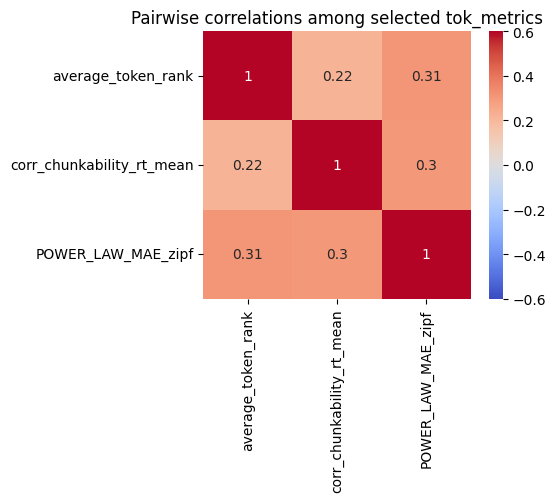

In [7]:
# Select tok_metrics highly correlated with Avg, but mutually low-correlated
import numpy as np
import pandas as pd

# Configuration (tweak as needed)
target_col = "Avg"
min_abs_corr = 0.20           # minimum |r(Avg, metric)| to be considered "high"
redundancy_threshold = 0.5   # maximum allowed |r| between selected metrics

# Use tokenizer metrics only, intersect with corr_matrix numeric columns and exclude join columns
available_tok_cols = [c for c in tok_cols if c in corr_matrix.columns and c not in join_cols]
# Correlation of each tok_metric with Avg
avg_corrs = corr_matrix.loc[target_col, available_tok_cols].dropna()
# Order by absolute correlation descending
ordered = avg_corrs.reindex(avg_corrs.abs().sort_values(ascending=False).index)
candidates = ordered[ordered.abs() >= min_abs_corr]

selected = []
for col, r in candidates.items():
    if not selected:
        selected.append(col)
        continue
    pairwise_abs = corr_matrix.loc[col, selected].abs()
    if (pairwise_abs <= redundancy_threshold).all():
        selected.append(col)

print("Top correlations to Avg (abs)")
print(ordered.abs().head(10))

print(f"\nSelected tok_metrics (|r(Avg)| >= {min_abs_corr} and mutual |r| <= {redundancy_threshold}):")
for col in selected:
    print(f"- {col}: r = {corr_matrix.loc[target_col, col]:.3f}")

sel_corr = corr_matrix.loc[selected, selected]
plt.figure(figsize=(max(6, len(selected)*0.9), max(5, len(selected)*0.8)))
sns.heatmap(sel_corr, annot=True, cmap="coolwarm", center=0, vmin=-0.6, vmax=0.6, square=True)
plt.title("Pairwise correlations among selected tok_metrics")
plt.tight_layout()
plt.show()


## Build simple composite features and assess correlation with Avg

We standardize the selected metrics (z-scores) and form simple pairwise composites:

- For each pair, compute the mean of the two standardized metrics as a composite feature.
- Correlate each composite feature with `Avg` to see whether small combinations capture more signal than single metrics.
- The resulting table ranks combinations by absolute correlation with `Avg`.


In [8]:
from itertools import combinations
import pandas as pd
from scipy.stats import zscore

modeling_df = for_corr.copy()
modeling_df[selected] = modeling_df[selected].apply(lambda s: pd.Series(zscore(s, nan_policy="omit", ddof=0), index=s.index)).fillna(0)

# Keep only target + standardized features
modeling_df = modeling_df[[target_col] + selected].copy()

# Build pairwise composite means
pairs = list(combinations(selected, 2))
composite_df = pd.DataFrame(
    {f"pair_mean-{a}-{b}": (modeling_df[a] + modeling_df[b]) / 2.0 for a, b in pairs},
    index=modeling_df.index,
)
modeling_df = pd.concat([modeling_df, composite_df], axis=1)

# Correlate composites with Avg (vectorized)
composite_corr_df = composite_df.corrwith(modeling_df[target_col]).to_frame("r")
composite_corr_df["abs_r"] = composite_corr_df["r"].abs()
composite_corr_df = (
    composite_corr_df
    .sort_values("abs_r", ascending=False)
    .rename_axis("composite_feature")
    .reset_index()
)

print(f"pairs: {len(pairs)} | composites: {composite_df.shape[1]}")
combos_df = pd.DataFrame(
    [{"k": 2, "features": (a, b), "composite_feature": f"pair_mean-{a}-{b}"} for a, b in pairs]
)

composite_corr_df.head(20)

pairs: 3 | composites: 3


,composite_feature,r,abs_r
0,pair_mean-average_token_rank-corr_chunkability...,-0.614243,0.614243
1,pair_mean-average_token_rank-POWER_LAW_MAE_zipf,-0.583442,0.583442
2,pair_mean-corr_chunkability_rt_mean-POWER_LAW_...,-0.508702,0.508702
